# Random processes and Monte Carlo Methods

Many processes in physics can be modelled as random, even though very few actually are. A classic example is the Brownian motion of a particle in a gas - if we knew the position and velocity of every gas molecule, then, in principle, we could calculate the exact trajectory of the particle. However, a random trajectory is a pretty good approximation and a lot easier to calculate. Some processes are truly random, such as radioactive decay, where we can get the probability of decay per unit time (the decay rate), but the exact moment is random and cannot be predicted.

![Brownian motion](images/output.gif)

<!-- ffmpeg -ss 00:00:10.000 -i brownian.mp4 -pix_fmt rgb24 -r 10  -t 00:00:34.000 -s 640x347 output2.gif -->

## Random numbers

![random](images/random.jpg)

To model random processes, we need to introduce a method for calculating random numbers...or rather *pseudorandom* numbers, as any algorithm (called a *random number generator*) based on a deterministic formula will never be truly random. Consider the following equation:

$$ x^\prime = (ax+c)\bmod m$$

with $a, b, c$ and $m$ integer constants and $x$ is an integer variable. If we iterate this, using $x^\prime$ as the new value of $x$ at each step, we get a set of integers. Let's try it in Python.

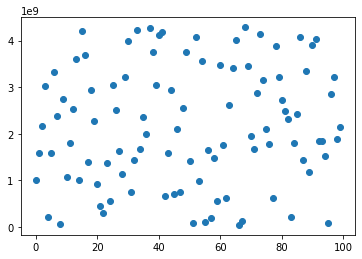

In [7]:
#from numpy import
import matplotlib.pyplot as plt 

N = 100 # number of iterations
a = 1664525
c = 1013904223
m = 4294967296
x = 1
numbers = []

for i in range(N):
    x = (a*x+c)%m
    numbers.append(x)
    
plt.plot(numbers,"o")
plt.show()

The resultant plot appears random, but it is clearly not - re-running the code will always generate the same set of numbers and if you know the formula, you can calculate exactly the numbers it will produce. This is known as a *linear congruential random number generator* (LCRNG), one of the most famous methods and, for certain problems, the numbers are random *enough*. 

#### Example - Initial conditions

The results are also very dependent on the choice of $a, b, c$ and $m$ and these were picked carefully - try some other possibilities and see how the plot changes.

While you always get the same result for a given starting $x$, you will get a different distributions for different initial values of $x$ - $x$ acts as the *seed* for the distribution. In general, the strong correlations between numbers in a LCRNG can introduce errors in computational physics problems and we want to use something much closer to giving us an uncorrelated sequence. As we have seen, this is available directly from `numpy`, using a *permutation congruential generator* (PCG64 specifically), which is a much more statistically accurate RNG.

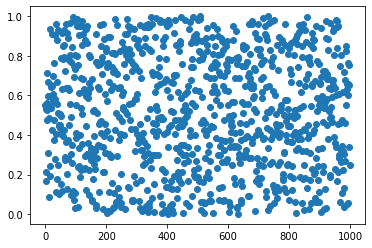

In [66]:
from numpy import random
import matplotlib.pyplot as plt 

rdist = random.rand(1000) # make a 1000 random numbers from 0 < x <= 1.

plt.plot(rdist,"o")
plt.show()

There are plenty of other options depending on the specific features you want and we will consider some of them shortly, but in general you should check the details on the `numpy` pages before you use them. However, there are some basic features of this new type of function that it is important to understand initially.

In [87]:
from numpy import random

print(random.rand())
print(random.rand())
print(random.rand())


0.8505415877340458
0.6086915966095477
0.6833051215165522


This seems very trivial, but is important to emphasize, unlike previous functions we have used, you will get a different number every time you call a `random` function, so you will need to store it at the point of creation if you want to use it again. This behaviour can be changed by using explicit *seeds*, much as we saw for the LCRNG. Then you will always get the same set of numbers - useful for testing purposes and for defeating *save-scummers*.

In [147]:
from numpy import random

random.seed(42)
print(random.rand(10))


[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258]


### Probabilities and bias

It is very common that we want an event to occur with a certain probability, for example, that a particle would move 20% of the time. This is very straightforward with random numbers and is termed "the toss of a biased coin" by statisticians. An example of a very biased coin...

In [161]:
from numpy import random

rng = random.default_rng() # now introducing the idea of generator-distribution pair.
#rng = random.default_rng(42) # set the generator with a seed

if rng.random()<0.2:
    print("Heads")
else:
    print("Tails")

Heads


#### Example - Biased coin

Expand the coin tossing code so that you can actually see the distribution of results over a significant sample in a plot.

#### Example - Decay of an isotope

The radioisotope $^{208}$Tl (thallium 208) decays to stable $^{208}$Pb (lead 208) with a half-life ($\tau$) of 3.053 minutes. Suppose we start with a sample of 1000 thallium atoms and simulate their decay over time using random numbers. On average, we know that radioactive decay is exponential, such that the number $N$ of atoms in our sample decays as:

$$N(t) = N(0)2^{-\frac{t}{\tau}} (=N(0)\text{e}^{-\frac{\ln2 t}{\tau}})$$

Then the fraction of atoms remaining after time $t$ is:

$$\frac{N(t)}{N(0)} = 2^{-\frac{t}{\tau}}$$

and the fraction that have decayed, which is equal to the probability that any given atom has decayed, is 1 minus that:

$$p(t) = 1 - 2^{-\frac{t}{\tau}}$$

We can code this by dividing our atoms into two sets, one of thallium and one of lead (with zero members at $t=0$).

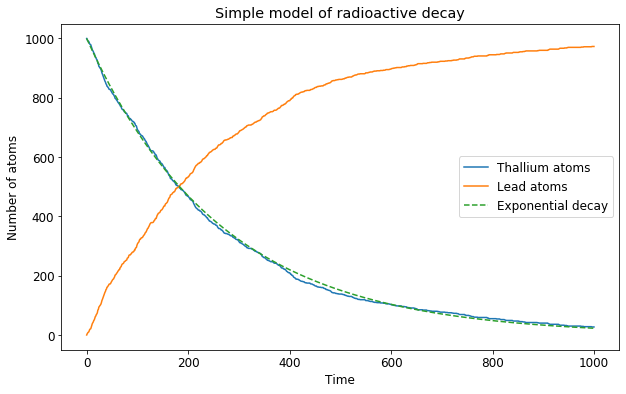

In [194]:
from numpy import random,linspace
import matplotlib.pyplot as plt

# Constants
NTl = 1000            # Initial number of thallium atoms
NPb = 0               # Initial number of lead atoms
tau = 3.053*60        # Half life of thallium in seconds
h = 1                 # Size of time-step in seconds
p = 1 - 2**(-h/tau)   # Probability of decay in one step
tmax = 1000           # Total time
steps = tmax//h       # Number of timesteps

# Lists of plot points

tpoints = linspace(0,tmax,steps+1)
exp_decay = NTl*2**(-tpoints/tau) # calculate the exact exponential decay (this is base-2, since we are talking about half-lives in radioactivity)

Tlpoints = []
Pbpoints = []
rng = random.default_rng() 

# Main loop
for t in tpoints:
    Tlpoints.append(NTl)
    Pbpoints.append(NPb)

    # Calculate the number of atoms that decay
    decay = 0
    for i in range(NTl):
        if rng.random()<p:
            decay += 1
    NTl -= decay
    NPb += decay

# Make the graph
plt.figure(figsize=(10,6))
plt.title('Simple model of radioactive decay')
plt.plot(tpoints,Tlpoints,label="Thallium atoms")
plt.plot(tpoints,Pbpoints,label="Lead atoms")
plt.plot(tpoints,exp_decay,"--",label="Exponential decay")
plt.xlabel("Time")
plt.ylabel("Number of atoms")
plt.legend()
plt.show()


We that the decay follows very closely the expected exponential decay, but it is not exact, as the simulation has captured the random nature of the process. 

### Nonuniform random numbers

The standard RNG from `numpy` such as `random` provide a uniform distribution of random numbers. However, in computational physics there are many situations where we are modelling processes that happen with nonuniform probability. In the radioactive example we just considered, we had $N$ atoms with a half-life of $\tau$ and the probability $p(t)$ that a particular particle decays in time $t$ is $1 - 2^{-\frac{t}{\tau}}$. Then the probability that it decays in an infinitesimal time $dt$ is:

$$1 - 2^{-\frac{dt}{\tau}} = 1 - \exp\left(-\frac{dt}{\tau}\ln 2 \right) = \frac{\ln 2}{\tau}dt$$

ignoring terms in $(dt)^2$ or smaller. If we now focus on a single atom, we can ask what is the probability that it decays between times $t$ and $t+dt$. Firstly, it must survive until time $t$, which has a probability of $2^{-\frac{dt}{\tau}}$ and then decay in the following interval $dt$. The total probability $P(t)dt$ is then:

$$P(t)dt = 2^{-\frac{dt}{\tau}} \frac{\ln 2}{\tau}dt$$

This is an example of a nonuniform probability distribution, as the decay times are proportional to $2^{-\frac{t}{\tau}}$, so that earlier decay times are more likely than later ones, although all are possible. The point of this, is that we now have a much more efficient method of solving the radioactive decay problem. Instead of running through every single atom at every timestep, we could just draw $N$ random numbers from this nonuniform probability distribution and count how many decay before a give time. To do this, we need a function that generates nonuniform random numbers and this is usually done by applying a *transformation method* to a standard RNG.

Suppose we have a source of random floating point numbers $z$ from a distribution $q(z)$ with a probability of getting a number between $z$ and $z+dz$ being $q(z)dz$. We also have a function $x=x(z)$, which gives us another random number from $z$, but with another distribution $p(x)$, different from $q(z)$. We want to define $x(z)$ such that $x$ has the distribution we want. The probability of generating a value of $x$ between $x$ and $x + dx$ is by definition equal to the probability of generating a value of $z$ in the equivalent interval:

$$p(x)dx = q(z)dz$$

Let's assume we are using the `numpy` function `random`, so what we have an equal probability of getting a number from zero to one. This means $q(z)=1$ from zero to one and is zero everywhere else. Then we can integrate the probabilities as follows:

$$\int_{-\infty}^{x(z)} p(x^\prime)dx^\prime = \int_0^z dz^\prime = z$$

If we can integrate the function on the left, we have an equation that must be solved by the value of $x(z)$, and if we can solve that, we get the function that we want. As an example, let us consider the set of random real numbers $x$ in the interval from zero to infinity for the exponential probability distribution:

$$p(x) = \mu e^{-\mu x}$$

using the same radioactive decay distribution $\mu = \ln 2/\tau$, which looks suspiciously normalized and integrable...

$$\mu \int_{0}^{x(z)} \text{e}^{-\mu x^\prime}dx^\prime = 1 - \text{e}^{-\mu x} = z$$

then:

$$x = -\frac{1}{\mu} \ln(1-z)$$

So we just need to generate uniform random numbers $z$ from zero to one and then feed them into this equation to get exponentially distributed $x$ values. Note that in principle whether you use $\ln(1-z)$ or $\ln(z)$ should not matter in terms of randomness, but in practice, your uniform distribution will generally either include 0 (`numpy.random`) or 1, not both (generators are usually in the *half-open interval*), and you should choose to avoid the discontinuity in the simulations. You can usually specify this when calling the RNG.

### Gaussian random numbers

A very common distribution in physics simulations is the Gaussian (or normal) distribution:

$$p(x) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{x^2}{2\sigma^2}\right)$$

where $\sigma$ is the width, or standard deviation, of the distribution and the factor is again for normalization. We can try the same transformation as before, such that:

$$\frac{1}{\sqrt{2\pi \sigma^2}} \int_{-\infty}^{x} \exp\left(-\frac{x^2}{2\sigma^2}\right)dx = z$$

While the integral can be solved, we end up with the following equation:

$$z = \frac{1}{2\sqrt{2\sigma^2}}\left(\text{erf}\left(\frac{x}{\sqrt{2\sigma^2}}\right) + \sigma \right) $$

which is not the best behaved function, as the solution is only valid for certain conditions. However, we can try to solve it numerically using a simpler form.


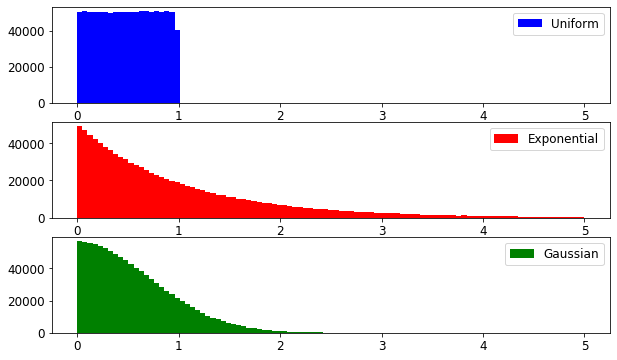

In [143]:
from numpy import random,linspace,log
import matplotlib.pyplot as plt
from scipy import special

rng = random.default_rng() 
points = 1000000

z = rng.random(points)
x1 = -log(1-z) # the solution for the simple exponential decay  
x2 = special.erfinv(z) # the solution of our Gaussian distribution above

bedges = linspace(0,5,100) 

plt.figure(figsize=(10,6))
plt.subplot(3,1,1) 
plt.hist(z,color='blue',bins=bedges,label='Uniform')
plt.legend()

plt.subplot(3,1,2)
plt.hist(x1,color='red',bins=bedges,label='Exponential')
plt.legend()

plt.subplot(3,1,3)
plt.hist(x2,color='green',bins=bedges,label='Gaussian')
plt.legend()

plt.show()

Many of the different attempts to find increasingly accurate approximations to a truly random Gaussian distribution are discussed in this [review](https://dl.acm.org/doi/10.1145/1287620.1287622). In the following example we switch fully to using the `numpy` options, as they are generally the fastest and most reliable.

#### Example - Rutherford scattering

![rutherford scattering](images/output2.gif)

Rutherford's group demonstrated in the early 20th century that alpha particles are scattered by the positive nucleus of an atom and that the angle through which it scatters obeys:

$$\tan\frac{1}{2}\theta = \frac{Ze^2}{2\pi \epsilon_0 Eb}$$

where $Z$ is the atomic charge of the nucleus, $e$ is the unit of elementary charge, $\epsilon_0$ is the permittivity of free space, $E$ is the kinetic energy of the incident $\alpha$ particle and $b$ is the impact parameter (the perpendicular distance between the particle's initial trajectory and the axis running through the nucleus.).

![rutherford angle](images/rutherford.jpg)

Consider a beam of particles with energy 7.7 MeV that has a Gaussian profile in both its $x$ and $y$ axes with a standard deviation of $\sigma = 0.01a_0$, where $a_0$ is the Bohr radius. The beam is fired directly at a gold atom and we can simulate the scattering by considering the behaviour of a million $\alpha$ particles and calculating how many *bounce back* on scattering i.e. the scattering angle is greater than 90$^{\text{o}}$. We can use the angle dependence of the impact parameter to change this to a condition for $b$. For $\theta = 90^{\text{o}}$:

$$ b = \frac{Ze^2}{2\pi \epsilon_0 E}$$

and if $b$ is less than this, the particle will bounce back.

In [75]:
from numpy import random,sqrt,pi,count_nonzero

# Constants
Z = 79 # atomic charge of nucleus
e = 1.602e-19 # unit of elementary charge
E = 7.7e6*e # kinetic energy
epsilon0 = 8.854e-12 # permittivity of free space
a0 = 5.292e-11 # Bohr radius
cutoff = Z*e*e/(2*pi*epsilon0*E) # scatter if b less than this
sigma = 0.01*a0 # standard deviation
N = 1000000 # number of incident particles

rng = random.default_rng() 

x = rng.normal(0, sigma, N)
y = rng.normal(0, sigma, N)
r = sqrt(x*x+y*y) # calculate r from x and y

particle_scatter = count_nonzero(r < cutoff)
scatter_percent = 100*particle_scatter/N

print("{} particles were reflected out of {} ({:.3f}%).".format(particle_scatter, N, scatter_percent))


1539 particles were reflected out of 1000000 (0.154%).


Rutherford was so amazed by this result in 1909, that he famously exclaimed that having the particle scatter "was about as credible as if you had fired a 15-inch shell at a piece of tissue paper and it had come back and hit you."

#### Example - Visualization

Modify the code to plot the distribution of alpha particles around the nucleus and highlight the scattered particles.

### Random number distributions

Let's now consider some of the different random function distributions available in `numpy`.

In [45]:
from numpy import random
import matplotlib.pyplot as plt

rng = random.default_rng() 

print('Random floats in [0,1]:')
print(rng.random(5))

print('\nRandom floats from normal distribution:')
print(rng.standard_normal(5))

print('\nRandom floats from Cauchy distribution:')
print(rng.standard_cauchy(5))

print('\nRandom integers from 1 to 10 inclusive:')
print(rng.integers(1,11,5)) # note will include 1 but not 11

print('\n4 by 5 array of random integers from 0 to 9:\n',rng.integers(0,10,(4,5)))

Random floats in [0,1]:
[0.31536848 0.93529772 0.89738888 0.50528478 0.09764386]

Random floats from normal distribution:
[-2.03901395  0.51684549  0.89410131 -1.12862489  1.04540951]

Random floats from Cauchy distribution:
[-0.60539632 -0.35374788 -1.23485618 -0.46621814  0.0096132 ]

Random integers from 1 to 10 inclusive:
[7 6 2 6 8]

4 by 5 array of random integers from 0 to 9:
 [[7 5 1 7 4]
 [2 6 6 4 7]
 [9 9 0 8 9]
 [2 0 7 6 2]]


We are considering the following distributions:

#### Normal

The probability density for the (normal) Gaussian distribution is:

$$p(x) = \frac{1}{\sqrt{ 2 \pi \sigma^2 }}\text{e}^{ - \frac{ (x - \mu)^2 } {2 \sigma^2} }$$

where $\mu$ is the mean and $\sigma$ the standard deviation. The square of the standard deviation, $\sigma^2$, is called the variance. The function has its peak at the mean, and its *spread* increases with the standard deviation (the function reaches 0.607 times its maximum at $x + \sigma$ and $x - \sigma$). This implies that normal is more likely to return samples lying close to the mean, rather than those far away.

#### Cauchy

The probability density function for the full Cauchy distribution is:

$$P(x; x_0, \gamma) = \frac{1}{\pi \gamma \bigl[ 1+(\frac{x-x_0}{\gamma})^2 \bigr] }$$

and the Standard Cauchy distribution just sets $x_0=0$ and $\gamma=1$. The Cauchy distribution arises in the solution to the driven harmonic oscillator problem, and also describes spectral line broadening. It also describes the distribution of values at which a line tilted at a random angle will cut the x axis. When studying hypothesis tests that assume normality, seeing how the tests perform on data from a Cauchy distribution is a good indicator of their sensitivity to a heavy-tailed distribution, since the Cauchy looks very much like a Gaussian distribution, but with heavier tails.

#### Exponential

The exponential probability density function is:

$$f(x; \frac{1}{\beta}) = \frac{1}{\beta} \exp(-\frac{x}{\beta})$$

for $x > 0$ and $0$ elsewhere. $\beta$ is the scale parameter, which is the inverse of the rate parameter $\lambda = 1/\beta$. The rate parameter is an alternative, widely used parameterization of the exponential distribution. The exponential distribution is a continuous analogue of the geometric distribution. It describes many common situations, such as the size of raindrops measured over many rainstorms, or the time between page requests to Wikipedia.

The differences can be seen more clearly if we plot histograms of the values for a much large sampling set.

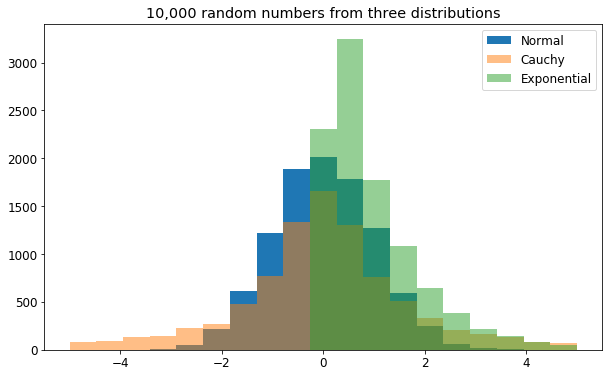

In [129]:
from numpy import random,linspace
import matplotlib.pyplot as plt

rng = random.default_rng() # current method for calling generators

numbers_std = rng.standard_normal(10000)
numbers_cau = rng.standard_cauchy(10000)
numbers_exp = rng.standard_exponential(10000)

bedges = linspace(-5,5,20) # pick bin edges for histogram
plt.figure(figsize=(10,6))
plt.rc('font',size=12)
plt.hist(numbers_std,bins=bedges,label='Normal')
plt.hist(numbers_cau,bins=bedges,label='Cauchy',alpha=0.5)
plt.hist(numbers_exp,bins=bedges,label='Exponential',alpha=0.5)
plt.title('10,000 random numbers from three distributions')
plt.legend()
plt.show()

### Example - Entropy and diffusion

We can use the random numbers to model the diffusion of the drop of dye in water using the concept of a *random walk*. For ease of display, we focus on a simulation in 2D, but the concept is the same in 3D.

We start with 400 particles in a square grid centered at (100,100). At each step, the program picks each particle and moves it (or not) one integer step in the $x$ and $y$ directions. If the move would take the particle beyond the boundary of space (200 $\times$ 200), then the particle bounces off the wall and moves in the other direction. The program plots the positions of all particles after each step.

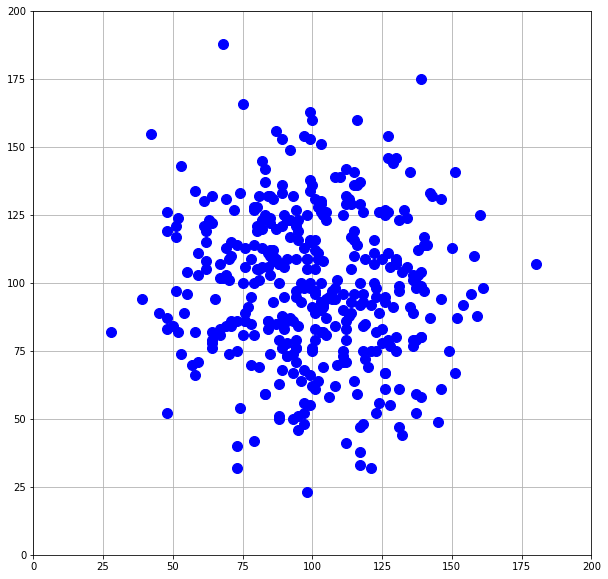

In [95]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
from numpy import random,ones
from IPython import display

plt.ion()

rng = random.default_rng() # current method for calling generators

# set up graph window
plt.figure(figsize=(10,10))

# the range (a,b), inclusive.
# Define droplet coordinates (all droplets) to be at point 100,100.
atoms = ones([400,2])*100

# show initial configuration
line, = plt.plot(atoms[:,0], atoms[:,1], 'bo', linewidth=2, markersize=10)

plt.xlim(0 ,200)
plt.ylim(0 ,200)
plt.grid(True)

# How many steps to take?
N = 1000

for i in range(N):
# Go through all atoms
    for j in range (400):
# Move each atom (or not) in the x and/or y direction - upper limit is not included in options.
        atoms[j,0] += rng.integers(-1,2)
        atoms[j,1] += rng.integers(-1,2)
# Check for boundary collision
        x,y = (atoms[j,0],atoms[j,1]) 
        if x == 200:
            atoms[j,0] = 198
        elif x == 0: 
            atoms[j,0] = 2
        if y == 200: 
            atoms[j,1] = 198
        elif y == 0: 
            atoms[j,1] = 2
        
# See how things look now - here we use set_xdata to change all the data for that axis.
    line.set_xdata(atoms[:,0]) 
    line.set_ydata(atoms[:,1])
    plt.draw()
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     time.sleep(0.01) 
    


We see that the dye gradually diffuses out, increasing the disorder in the system - the *entropy*. For a system of discrete states like this, we can defined the entropy exactly:

$$S = -k_{B} \sum_{i} P_{i}\ln P_{i}$$

where $P_{i}$ is the probability of finding a particle in state $i$. 

If we split up our system into a grid of square states, the probability (or relative frequency) of particles in each state is the number of particles per square, divided by the total number of particles. 

The entropy of the initial state is zero for this particular choice of states. The relative frequency for each state is zero for all but the center state, since they’re all empty. So $P_{i} = 0$ for all but the center square. In the center square, $P_{i} = 1$ since all of the particles are there, and $\ln 1 = 0$ so the total entropy is $S = 0$.

If we track the number of particles in each state as a function of the diffusion step we can see how entropy changes with time...it should increase.

In [73]:
%%timeit # comment out print statements when testing speed
import matplotlib.pyplot as plt
from numpy import random,ones,zeros,log,where,sum

rng = random.default_rng() # current method for calling generators

# the range (a,b), inclusive.
# Define droplet coordinates (all droplets) to be at point 100,100.
particles = 400
atoms = ones([particles,2])*100

# How many steps to take?
N = 1000
# estimate the entropy
grid = 8 # determines the resolution that you can track the entropy
box = 200
cell = int(box/grid)

entropy = zeros(N)               
kb = 8.617333262145e-5 # in eV/K

for i in range(N):
    state_count = zeros((grid,grid)) # initialize state count
    s = 0.0 # initialize sum
# Go through all atoms
    for j in range (particles):
# Move each atom (or not) in the x and/or y direction - upper limit is not included in options.
        atoms[j,0] += rng.integers(-1,2)
        atoms[j,1] += rng.integers(-1,2)
# Check for boundary collision
        x,y = (atoms[j,0],atoms[j,1]) 
        if x == box:
            atoms[j,0] = 198
        elif x == 0: 
            atoms[j,0] = 2
        if y == box: 
            atoms[j,1] = 198
        elif y == 0: 
            atoms[j,1] = 2
# entropy calculation     
        for gx in range(grid):
            for gy in range(grid):
                if x in range(gx*cell,(gx+1)*cell) and y in range(gy*cell,(gy+1)*cell):
                    state_count[gx,gy] += 1
    
    for gx in range(grid):
            for gy in range(grid):
                if state_count[gx,gy] != 0.0:
                    state_prob = state_count[gx,gy]/particles
                    s += (log(state_prob))*state_prob

    entropy[i] = -kb*s

#    entropy[i] = -kb*(log(state_count[where(state_count != 0)]/particles)*(state_count[where(state_count != 0)]/particles)).sum()

# plot the entropy change as the system develops
# plt.plot(entropy)
# plt.xlabel("Diffusion step")
# plt.ylabel("Entropy")
# plt.show()

2min 11s ± 3.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Monte Carlo Integration

In principle, we can solve the particle scattering problem analytically, although it is rather tedious using the $\text{erf}$ function. However, one approach to find the Gaussian distribution is by transforming to polar coordinates, which gives much more straightforward integrals. We will skip the derivation here, as it is not very important to the discussion, but then the normalized distribution function for $r$ is:

$$ p(r) = \frac{r}{\sigma^2}\exp\left(-\frac{r^2}{2\sigma^2}\right)$$

Then the probability of scattering through more than 90$^{\text{o}}$, i.e. when $r$ is from zero to $b$, is:

$$\frac{1}{\sigma^2}\int_0^b\exp\left(-\frac{r^2}{2\sigma^2}\right)rdr = 1 - exp\left(-\frac{b^2}{2\sigma^2}\right) = 1 - exp\left(-\frac{z^2e^4}{8\pi^2\epsilon^2_0\sigma^2E^2}\right) $$

In [90]:
from numpy import pi,exp

# Constants
Z = 79 # atomic charge of nucleus
e = 1.602e-19 # unit of elementary charge
E = 7.7e6*e # kinetic energy
epsilon0 = 8.854e-12 # permittivity of free space
cutoff = Z*e*e/(2*pi*epsilon0*E)
a0 = 5.292e-11 # Bohr radius
sigma = 0.01*a0 # standard deviation
N = 1000000

particle_prob = 100*(1 - exp(-(cutoff*cutoff)/(2*sigma*sigma)))
print("{:.3f}% of particles were reflected.".format(particle_prob))


0.156% of particles were reflected.


This is in very good agreement with the numerical result...it is also a very fundamental demonstration that we can calculate the approximate value of an integral with random processes. This is the opposite approach to the one we usually take in physics, writing down an analytic form that describes the average properties of a physical process with random elements. We are starting with an exact problem e.g. solving an integral, and find an approximate solution by running random processes in a simulation.

Consider the following integral:

$$I = \int_0^2\sin^2\left[\frac{1}{x(2-x)}\right]dx$$

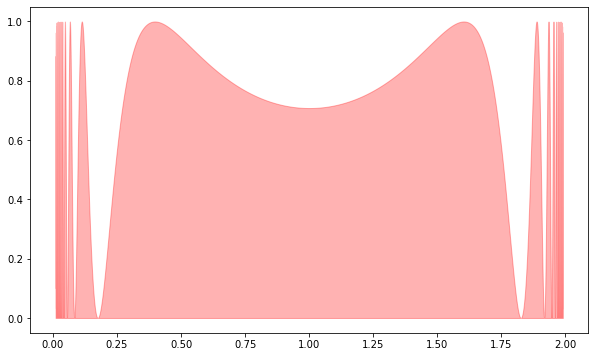

In [113]:
from numpy import sin,linspace
import matplotlib.pyplot as plt

x = linspace(0.01,1.99,10000)
y = (sin(1/(x*(2-x))))**2

plt.figure(figsize=(10,6))
plt.fill_between(x, y,color='red',alpha=0.3)          
plt.show()

The function is well-behaved in the majority of its range, but it varies infinitely fast at the edges. However, the area under the curve (shaded) is clearly finite and must be less than 2, so the integral must be well-defined ([Wolfram](https://www.wolframalpha.com/input/?i=integrate+%28sin%281%2F%28x*%282-x%29%29%29%29**2+from+0+to+2) has no indefinite solution, but gives us 1.4514 in the range of interest). There are no obvious methods to solve this analytically and the basic numerical methods you saw in lecture 2 will not handle the edge regions. So let's try a random approach...

The shaded area $I$ is bounded by a rectangle (2,1) with an area $A=2$ and if we choose a random point in the rectangle, the chance that it is with $I$ is $p=I/A$. If generate a large number of random points $N$ and count the number $k$ in the shaded region, then the fraction of points $k/N$ in the region should be a decent approximation for $p$ such that:

$$I \simeq \frac{kA}{N}$$

This technique is known as *Monte Carlo integration* after the casino in Monaco. We can easily try this approach on our integral with Python.

In [1]:
from numpy import random,sin,count_nonzero
N=10000
area=2
rng = random.default_rng()

x = 2*rng.random(N) # space is twice the length random number in x, but this could be also done with specific numpy distributions
y = rng.random(N)
fx = (sin(1/(x*(2-x))))**2

under_curve = count_nonzero(y < fx)
integral = area*under_curve/N
print(integral)

1.4512


We get pretty good agreement - the accuracy scales with the number of sampling points you use, which is not an issues in this case, but would be for functions that are more expensive to evaluate. Try it. You can also change the random distributions used and see how it affects the result. Do you understand why?

You might notice that the improvement in accuracy with increased sampling is not that good and this is one of the main disadvantages of the Monte Carlo approach. The probability that a single point falls below the curve is $p=I/A$ and the probability above $1-p$. Then the probability that a particular $k$ of our points fall below and the remaining $N-k$ fall above is thus $p^k(1-p)^{N-k}$. But there are $(^N_k)$ ways (permutation theory in Cauchy notation) to choose the $k$ points out the $N$ total, so the total probability $P(k)$ that we get exactly $k$ points below the curve is:

$$P(k)=\left(N \atop k\right)p^k(1-p)^{N-k}$$

We can get the variance of this distribution $(\langle k^2\rangle-\langle k\rangle^2)$ easily:

$$ \langle k\rangle = \sum_{k=0}^NkP(k)=Np$$
$$ \langle k^2\rangle = \sum_{k=0}^Nk^2P(k)=N(N-1)p^2+Np$$

such that:

$$\text{var}k = (\langle k^2\rangle-\langle k\rangle^2) = Np(1-p) = N\frac{I}{A}\left(1-\frac{I}{A}\right)$$

with a standard deviation equal to the square root of the variance ($\sqrt{\text{var}k}$). Finally we can get an expected error on the random integral solution by substituting for $I \simeq \frac{kA}{N}$:

$$\sigma = \sqrt{\text{var}k}\frac{A}{N} = \frac{\sqrt{I(A-I)}}{\sqrt N}$$

so the error varies with $N^{-\frac{1}{2}}$, which is not great...increasing the sampling by a factor of 100 will only reduce the error by 10. Standard numerical methods like trapezoidal rule have errors that scale with $N^{-2}$ and Simpson's rule with $N^{-4}$. Hence, the Monte Carlo approach only makes sense for pathological integrands or, as we will see a little later, for integrals in high dimensions.

### The Mean Value Method

The are plenty of methods that improve upon the basic Monte Carlo approach and one of the most common is the *mean value method*. Let's consider the general integral problem:

$$I = \int_a^bf(x)dx$$

The average value of $f(x)$ in the range $a$ to $b$ is:

$$\langle f\rangle = \frac{1}{b-a}\int_a^bf(x)dx = \frac{I}{b-a}$$

so $I = (b-a)\langle f\rangle$ and if we can estimate $\langle f\rangle$ we can get $I$. A simple way to estimate $\langle f\rangle$ is just to measure $f(x)$ at $N$ points $x_i$ chosen uniformly at random between $a$ and $b$, and calculate $\langle f\rangle \simeq N^{-1}\sum_{i=1}^Nf(x_i)$. Then:

$$ I \simeq \frac{b-a}{N}\sum_{i=1}^Nf(x_i)$$

To compare to the standard method, we can estimate the error from the variance $(\langle f^2\rangle-\langle f\rangle^2)$ as before:

$$ \langle f\rangle = \frac{1}{N}\sum_{i=1}^Nf(x_i)$$

$$ \langle f^2\rangle = \frac{1}{N}\sum_{i=1}^N[f(x_i)]^2$$

The variance of the sum for the integral is $N\text{var}f$ and the standard deviation is the square root of this, finally giving:

$$ \sigma = \frac{b-a}{N}\sqrt{N\text{var}f} = (b-a)\frac{\sqrt{\text{var}f}}{\sqrt{N}}$$

The error is once again proportional to $N^{-\frac{1}{2}}$, but the factor is smaller, so this method is always more accurate for a given sample.

#### Example - Error

Calculate the integral using the standard and mean value methods, and plot the estimate and associated standard deviation as a function of $N$.

### Integrals in many dimensions

Using the standard methods introduced in lecture 2, we saw that performing integrals in two-dimensions requires a two-dimensional grid, and in three-dimensions requires a three-dimensional grid and so on. Once we get to higher dimensional integrals this can become very expensive. However, the mean value method generalizes quite simply to solve integrals of any dimension, such that:

$$ I \simeq \frac{V}{N}\sum^N_{i=1}f(\textbf{r}_i)$$

where the points $\textbf{r}_i$ are picked randomly from the volume $V$. These types of integrals are often encountered when using prediction models in the financial markets, a source of employment for many physicists...

![monte_carlo](images/monte.png)

### Importance sampling

If we consider the following integral:

$$ I = \int_0^1\frac{x^{-1/2}}{e^x+1}dx$$

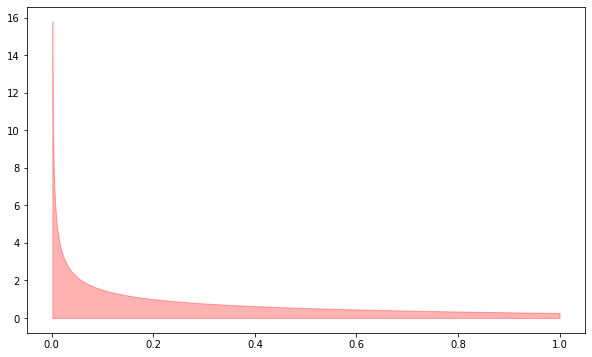

In [489]:
from numpy import exp,linspace
import matplotlib.pyplot as plt

x = linspace(0.001,1,10000)
y = (x**-0.5)/(exp(x)+1)

plt.figure(figsize=(10,6))
plt.fill_between(x,y,color='red',alpha=0.3)          
plt.show()

On the surface it is clearly finite in value, but if we apply the Monte Carlo technique, any points close to $x=0$ will give a very large contribution to the result - this will cause a lot of variance between runs...not a great feature of a reliable simulation.

In [612]:
from numpy import random,exp,sum
N=10000
a=0
b=1

rng = random.default_rng()

x = rng.random(N)

integral = (((b-a)/N)*(x**-0.5)/(exp(x)+1)).sum()

print(integral)

0.8229741987936715


This problem can be avoided by using a non-uniform sampling of points in the interval and is called *importance sampling*. For any general function $g(x)$, we can defined a weighted average over the interval from $a$ to $b$ as:

$$\langle g\rangle_w = \frac{\int_a^bw(x)g(x)dx}{\int_a^bw(x)dx} $$

where $w(x)$ is the weighting function we choose for the problem at hand. For a one-dimensional integral:

$$I = \int_a^bf(x)dx$$

For $g(x) = f(x)/w(x)$, we have:

$$\left\langle \frac{f(x)}{w(x)} \right\rangle_w = \frac{\int_a^bw(x)f(x)/w(x)dx}{\int_a^bw(x)dx} = \frac{\int_a^bf(x)dx}{\int_a^bw(x)dx} = \frac{I}{\int_a^bw(x)dx}$$

$$ I = \left\langle \frac{f(x)}{w(x)} \right\rangle_w \int_a^bw(x)dx$$

To actually solve this, let's define probability density function:

$$ p(x) = \frac{w(x)}{\int_a^bw(x)dx}$$

which is similar to a a weight function, but normalized so that its integral is 1. Sampling $N$ points randomly in this density gives us a probability $p(x)dx$ of getting a value between $x$ and $x+dx$, and the average number of samples that fall in this interval is $Np(x)dx$. For any function $g(x)$

$$ \sum_{i=1}^Ng(x_i) \simeq \int_a^bNp(x)g(x)dx$$

with the accuracy increasing with $N$. Then the general weighted average of the function $g(x)$ is:

$$ \langle g\rangle_w = \frac{\int_a^bw(x)g(x)dx}{\int_a^bw(x)dx} = \int_a^bp(x)g(x)dx \simeq \frac{1}{N}\sum_{i=1}^Ng(x_i)$$

and 

$$ I \simeq \frac{1}{N}\sum_{i=1}^N\frac{f(x_i)}{w(x_i)}\int_a^bw(x)dx$$

For no weighting $w(x)=1$ and we recover our original form of the integral.

Returning to the original divergent integral, if we choose $w(x) = x^{-1/2}$ then $f(x)/g(x) = (e^x+1)^{-1}$, which is finite and well-behaved over the interval. To solve it, we need to draw random values from the following distribution:

$$p(x) = \frac{x^{-1/2}}{\int_0^1x^{-1/2}dx} = \frac{1}{2\sqrt{x}}$$

Using the transformation matrix method:

$$\int_{-\infty}^{x(z)}p(x)dx=z$$

with $p(x) = \frac{1}{2\sqrt{x}}$ we have:

$$\int_{0}^{x}\frac{1}{2\sqrt{x}}dx= \frac{1}{2}\left[2\sqrt{x}\right]^x_0 = z$$

so $x = z^2$ gives us the distribution we need. 

In [655]:
from numpy import random,sum,exp
N=10000

rng = random.default_rng()

z = rng.random(N)
x = z*z

integral = ((2/N)/(exp(x)+1)).sum()

print(integral)

0.8408444126517298


#### Example - Variance

Use the codes for the uniform and non-uniform solutions to the divergent integral and make a comparative plot of the variance in answers.

## Monte Carlo Simulation

Any computational physics approach that uses random numbers to estimate an outcome from a physical process is know as a *Monte Carlo Simulation*. We have already seen two examples, the radioactive decay and Rutherford scattering. These methods are commonly used in every branch of physics, but are most commonly seen in statistical physics.

### Importance sampling and statistical mechanics

A fundamental problem of statistical mechanics is to calculate the average value of interest in a physical system in thermal equilibrium at temperature $T$. We don't know the exact state of the system, only that it will pass through a succession of states, such that at any particular moment the probability of its occupying state $i$ with energy $E_i$ is given by the Boltzmann formula:

$$ P(E_i) = \frac{e^{-\beta E_i}}{Z} $$

where $Z = \sum_i e^{-\beta E_i}$, $\beta = 1/k_BT$ and $k_B$ is Boltzmann's constant. Then the average value of a quantity $X$ that takes the value $X_i$ in the $i$th state is:

$$ \langle X\rangle = \sum_iX_iP(E_i)$$

For simple cases, like the quantum harmonic oscillator we saw in lecture 1, we can calculate this exactly, but generally we need to use a numerical approach as the number of states is far too large. For example, there are $10^{23}$ molecules in a single mole of a gas and even if they had only two quantum states (they have many more), then the total number of states in the whole system would be $2^{10^{23}}$...quite many...

Instead of a direct solution for $Z$ we apply the Monte Carlo approach, in a similar fashion to the way we used it to solve integrals. The equivalent for a sum is to choose a set of terms from the sum at random and add those. Thus, instead of summing over all the states of the system, we would choose $N$ states at random, denoted by $k = 1\dots N$ and then calculate:

$$ \langle X\rangle \simeq \frac{\sum_{k=1}^NX_kP(E_k)}{\sum_{k=1}^NP(E_k)}$$

with the denominator add to normalize the weighted average (not needed in the original as  $\sum_{i}P(E_i)=1$ by definition). Unfortunately, this doesn't work, as the Boltzmann probability is exponentially small for any state with energy $E_i \gg k_bT$, which is most of them. If almost all states contribute very little to the sum and we take a random sample, it is very likely we will not capture the important states, and our approximation will be poor. 

However, we have already seen how we can use *importance sampling* to weight our random number selection in these kinds of problems...in fact, the name comes from being applied in exactly this context. So we can define a nonuniform distribution that focuses on the states that make the most contribution. For any quantity $g_i$ that depends on the states $i$, we can define a weighted average over states:

$$ \langle g\rangle_w = \frac{\sum_iw_ig_i}{\sum_iw_i}$$

where $w_i$ is any set of weights we choose. Making the particular choice $g_i = X_iP(E_i)/w_i$ this gives:

$$ \left\langle \frac{X_iP(E_i)}{w_i}\right\rangle_w = \frac{\sum_iw_iX_iP(E_i)/w_i}{\sum_iw_i} = \frac{\sum_iX_iP(E_i)}{\sum_iw_i} = \frac{\langle X\rangle}{\sum_iw_i}$$

such that:

$$ \langle X\rangle = \left\langle \frac{X_iP(E_i)}{w_i}\right\rangle_w \sum_iw_i$$

We can make an estimate of this expression by selecting a set of $N$ sample states randomly but nonuniformly, such that the probability of choosing state $i$ is:

$$p_i = \frac{w_i}{\sum_jw_j}$$

and the weighted average over states is:

$$\langle g \rangle_w \simeq \frac{1}{N}\sum_{k=1}^Ng_k$$

where $g_k$ is the value of the quantity $g$ in the $k$th state we select. This gives us:

$$ \langle X\rangle \simeq \frac{1}{N}\sum_{k=1}^N\frac{X_kP(E_k)}{w_k}\sum_iw_i$$

with the first sum over the states sampled and the second over all states. We need to pick $w_i$ so that most of the samples are in the region where $P(E_i)$ is big and we also need $\sum_iw_i$ to be solvable analytically, or the whole approach is useless...but this is easy to satisfy. Let us choose $w_i = P(E_i)$, then we have $\sum_iw_i = \sum_iP(E_i) = 1$ by definition and a simple form of $X$:

$$ \langle X\rangle \simeq \frac{1}{N}\sum_{k=1}^NX_k$$

So we just choose $N$ states in proportion to their Boltzmann probabilities and take the average of $X$ over all of them (we are sampling the states the system passes through and calculating the average). The more states we use, the more accurate the result.

### Markov chain method

Unfortunately, it is not easy to choose states in proportion to their Boltzmann probabilities as it includes the *partition function*, defined as a sum over states...which we are really trying to avoid. However, we can use the *Markov chain* method to solve this problem without summing over the states. 

A Markov chain is a string of states and when we consider a single state $i$, the next state will not be random, but a small change of $i$ e.g. a change in the quantum level of a single gas molecule. The choice of the new state is determined probabilistically by a set of *transition probabilities* $T_{ij}$. If we pick $T_{ij}$ correctly, we can make sure that the probability of visiting any state on the chain is exactly the Boltzmann probability $P(E_i)$. How to pick the probabities is the immediate question?

Given that we must end up in some state on every step of the Markov chain:

$$ \sum_jT_{ij}=1$$

Then we must also satisfy the condition that:

$$ \frac{T_{ij}}{T_{ji}} = \frac{P(E_i)}{P(E_j)} = \frac{e^{-\beta E_i}/Z}{e^{-\beta E_j}/Z} = e^{-\beta(E_j-E_i)}$$

In other words, we are choosing a particular value for the ratio of the probability to go from $i$ to $j$ and back again and the partition function has been cancelled out of the equation. Once satisfied, with the probability that we are in state $i$ on one particular step of the Markov chain is equal to the Boltzmann probability for all $i$, then the probability of being in state $j$ on the next step is the sum of the probabilities that we got there from every other possible state $i$:

$$ \sum_iT_{ij}P(E_i) = \sum_iT_{ji}P(E_j) = P(E_j)\sum_iT_{ji} = P(E_j)$$

So, if the probability is correct on one step, it will be correct on all of them. We can also show that for another distribution, e.g. random, on the Markov chain it will converge eventually to the Boltzmann distribution, as it is a *fixed point* on the Markov chain. 

Actually finding the probabilities is commonly done with the *Metropolis algorithm*.

![Markov chain](images/markov.gif)

In this approach, it is important to understand that we can visit the same state twice, even consecutively, as this still counts as a *step*. You can see this in the animation. 

Let us keep the example of a gas, and we randomly choose a molecule and then choose the next one to be randomly one energy level up or down from the current one. Then we either *accept* or *reject* the new state with *acceptance probability* $P_a$ given by:

$$ P_A = 
\begin{cases}
1 & \text{if} E_j \leq E_i \\
e^{-\beta(E_j-E_i)} & \text{if} E_j \gt E_i \\
\end{cases}
$$

So if the move is rejected, we do nothing. Otherwise, we change the system to the new state according to the change in energy. If it reduces or maintains the energy, we always accept it, but if it increases the energy we *may* also accept it, with the probability given. Under this scheme the total probability $T_{ij}$ of making a move from state $i$ to state $j$ is the probability that we choose that move out of all possibilities ($1/M$), times the probability that we accept the move. For $E_j \gt E_i$ then 

$$ T_{ij} = \frac{1}{M} \times e^{-\beta(E_j-E_i)} \quad \text{and} \quad T_{ji} =  \frac{1}{M} \times 1$$

and the ratio of the two is:

$$ \frac{T_{ij}}{T_{ji}} = \frac{e^{-\beta(E_j-E_i)}/M}{1/M} = e^{-\beta(E_j-E_i)} $$

Then if $E_j \leq E_i$:

$$ T_{ij} = \frac{1}{M} \times 1 \quad \text{and} \quad T_{ji} =  \frac{1}{M} \times e^{-\beta(E_i-E_j)}$$

Giving a ratio of:

$$ \frac{T_{ij}}{T_{ji}} =\frac{1/M}{e^{-\beta(E_i-E_j)}/M} = e^{-\beta(E_j-E_i)} $$

Both of these satisfy our definition. A practical solution of our problem would involve the following steps:

1. Choose a random starting state.
2. Choose a move uniformly at random from a set of allowed moves.
3. Calculate the value of the acceptance probability $P_a$.
4. With probability $P_a$ accept the move, changing the state of the system or reject it.
5. Measure the value of interest $X$ in the current state and add it to the running sum.
6. Return to 2.

At the end, we divide the sum by the number of steps to get our estimate of the average value $\langle X \rangle$.

Before we try an example of this, there are a few important points to note:

1. As mentioned, steps where nothing changes must still be counted.
2. $M$ must be the same when going from $i$ to $j$ and from $j$ to $i$.
3. The move set must be chosen so you get to every state - known as *ergodic*.
4. Although the system will always get to the Boltzmann distribution, this *equilibration* time depends specifically on the complexity of your system. 

#### Example - Monte Carlo simulation of an ideal gas

The quantum states of a particle or atom of mass $m$ in a cubic box of length $L$ on each side have three integer quantum numbers $n_x,n_y,n_z = 1\dots\infty$ and energies given by

$$ E(n_x,n_y,n_z) = \frac{\pi^2\hbar^2}{2mL^2}(n_x^2+n_y^2+n_z^2)$$

In an ideal gas, the atoms do not interact with each other in any way, so their total energy is just a sum of the individual energies:

$$ E = \sum_{i=1}^NE(n_x^{(i)},n_y^{(i)},n_z^{(i)})$$

where $n^{(i)}$ is the value of the quantum number $n$ for the $i$th atom.

We first need to choose a move set. In this case we will let the move set be the set of all moves of a single atom to one of the six neighbouring states where $n$ differs by $\pm 1$. When we make such a move, just one term in the total energy changes. If, for example, $n_x^{(i)}$ increases by 1, then the energy change will be:

$$\Delta E = \frac{\pi^2\hbar^2}{2mL^2}[(n_x+1)^2+n_y^2+n_z^2] - \frac{\pi^2\hbar^2}{2mL^2}(n_x^2+n_y^2+n_z^2)$$

$$ = \frac{\pi^2\hbar^2}{2mL^2}[(n_x+1)^2-n_x^2)] = \frac{\pi^2\hbar^2}{2mL^2}(2n_x+1) $$

Similarly, if $n_x^{(i)}$ decreases by 1, then the energy change will be:

$$\frac{\pi^2\hbar^2}{2mL^2}(-2n_x+1) $$

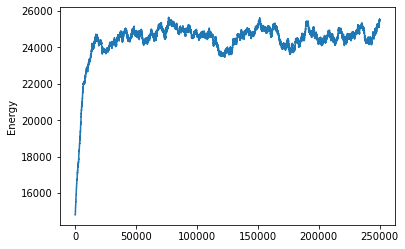

In [40]:
from numpy import random,sum,exp,pi,ones
import matplotlib.pyplot as plt

m = 1 # natural units
hbar = 1 # natural units
T = 10.0 # kbT
N = 1000 # number of particles
steps = 250000
E = 3*N*pi*pi/2 # initial energy

# Create a 2D array to store the quantum numbers
n = ones([N,3],int) # all particles in the ground state, n=1

rng = random.default_rng()

eplot = []

for k in range(steps):

    # Choose the particle and the move
    i = rng.integers(N)
    j = rng.integers(3)
    if rng.random()<0.5:
        dn = 1
        dE = (2*n[i,j]+1)*pi*pi/2
    else:
        dn = -1
        dE = (-2*n[i,j]+1)*pi*pi/2

    # Decide whether to accept the move, noting that we cannot go below n=1 as the ground state.
    if n[i,j]>1 or dn==1:
        if rng.random()<exp(-dE/T):
            n[i,j] += dn
            E += dE

    eplot.append(E)

plt.plot(eplot)
plt.ylabel("Energy")
plt.show()


#### Example - Temperature

Explore how the equilibration time and average energy is affected by the temperature of the run. Plot the analysis.

## Simulated Annealing

For many problems in physics, we are interested in finding the *global minimum* of a function and just finding the *local minimum* with respect to nearby points is not enough. As an example, for many molecular systems there are many stable configurations that are local minima, but only one configuration with the lowest energy i.e. the global minimum. Finding such minima is a tough problem and remains an active area of research - the minimization techniques discussed in earlier lectures cannot solve for global minima. 

![Energy Minimums](images/minimum.png)

One common approach based on statistical physics is known as *simulated annealing*. We return to our physical system in thermal equilibrium at temperature $T$ such that the probability of its occupying state $i$ with energy $E_i$ is given by the Boltzmann formula:

$$ P(E_i) = \frac{e^{-\beta E_i}}{Z} $$

where $Z = \sum_i e^{-\beta E_i}$, $\beta = 1/k_BT$ and $k_B$ is Boltzmann's constant. Let's assume the system has a unique ground state ($E_i = 0$) and all other states are higher in energy ($E_i \gt 0$). We now cool the system to absolute zero and in the limit $T \rightarrow 0$ we have $\beta \rightarrow \infty$ and $e^{-\beta E_i} \rightarrow 0$, except the ground state, where $e^{-\beta E_i} = e^{0} = 1$. Thus in this limit $Z = 1$ and:

$$ P(E_i) = 
\begin{cases}
1 & \text{for} \quad E_i = 0\\
0 & \text{for} \quad E_i \gt 0\\
\end{cases}
$$

So the system must be in the ground state. Hence, we could apply our computational strategy using Markov chain Monte Carlo to find the ground state of any physical system by gradually reducing the temperature. In fact, this approach can be applied to any function $f(x,y,z,\dots)$ where $x,y,z,\dots$ define the *state* of the system and $f$ defines the *energy*. It can also be used to maximize a function by using $-f$ as the energy. 

However, our algorithm has a probability to move to states higher in energy that scales with temperature. At zero temperature, it will reject all moves to higher energy states and if we sitting in a local minimum, we are stuck - the global minimum is out there, but we cannot sample it. But nature offers a way out of this problem or rather materials physics...it has been commonly know for centuries, that when working with heated materials e.g. glass, metal, it is important to cool them slowly - *annealing* it - to produce a strong final material. This is because the heating produces disorder in the material and if cooled quickly it will be *frozen in* weakening the structure - the disorder is trapped at local minima. Slow cooling allows for atoms to re-arrange into more ordered states with lower final energies. This can be directly applied to our Monte Carlo approach (at least approximately, as accuracy depends on the rate of cooling we use).

![anneal](images/anneal.jpg)

Practically we just lower the temperature of the system until its state stops changing. The initial temperature should be chosen so that the system equilibrates quickly and $k_BT$ should generally be significant higher than the typical energy change in a Monte Carlo move. Then we have $\beta (E_i - E_i) \ll 1$ and $P_a \simeq 1$ for all moves, meaning the system will be rapidly randomized no matter the starting configuration. Typically an exponential *cooling schedule* is used:

$$ T = T_0e^{-t/\tau}$$

where $T_0$ is the initial temperature and $\tau$ is the time constant. Typically the slower the cooling (and larger $\tau$) the better the results, but longer the calculation takes...the usual computational physics problem.

#### Example: The travelling salesperson

We can apply this technique to the famous *travelling salesperson* problem, where we want to optimize the journey between $N$ cities - this is a *hard* problem in computational physics and offers a demonstration of the power of the annealing technique. 

![Salesperson](images/salesperson.png)

We consider the two-dimensional problem, where the traveller moves in straight lines between cities. We number the cities $i$ in the order they are visited starting with zero and we denote the position of the city by a vector $\textbf{r}_i = (x_i,y_i)$ with $\textbf{r}_N = \textbf{r}_0$ since the traveller must return home. The total distance travelled is then:

$$ D = \sum_{i=0}^{N-1}|\textbf{r}_{i+1}-\textbf{r}_i|$$

We want to minimize this over all possible routes. A suitable move set for our Markov chain is to repeatedly swap two cities in a possible route and see if this increases the total distance, accepting shortening swaps immediately and others using the Metropolis probability. We need to swap cities back after a rejected move and now we must track temperature via the cooling schedule.

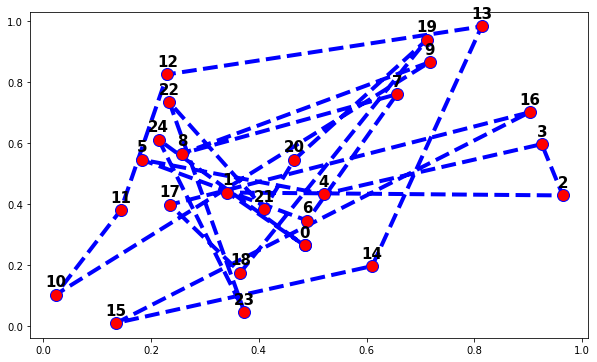

In [106]:
from numpy import random,sqrt,exp,empty,sum,arange
import matplotlib.pyplot as plt
import time

rng = random.default_rng() # set the generator

N = 25 # number of cities
R = 0.02 # graphics option
Tmax = 10.0 # starting temperature
Tmin = 1e-3 # final temperature
tau = 1e4 # cooling constant

# Function to calculate the magnitude of a vector
def mag(x):
    return sqrt(x[0]**2+x[1]**2)

# Function to calculate the total length of the tour
def distance():
    s = 0.0
    for i in range(N):
        s += mag(r[i+1]-r[i])
    return s

# Choose N city locations and calculate the initial distance
r = empty([N+1,2],float)
for i in range(N):
    r[i,0] = rng.random()
    r[i,1] = rng.random()
r[N] = r[0]
D = distance()

#plot the cities
plt.figure(figsize=(10,6))
c = arange(0, N+1, 1) 
for label in range(N):
    plt.annotate(label, (r[label,0],r[label,1]),fontsize=15,fontweight='bold',xytext=(0, 5),textcoords="offset points",ha='center', va='bottom')
plt.plot(r[:,0],r[:,1],color='blue', linestyle='dashed', linewidth='4',marker='o',
     markerfacecolor='red', markersize=12) 
plt.show()    


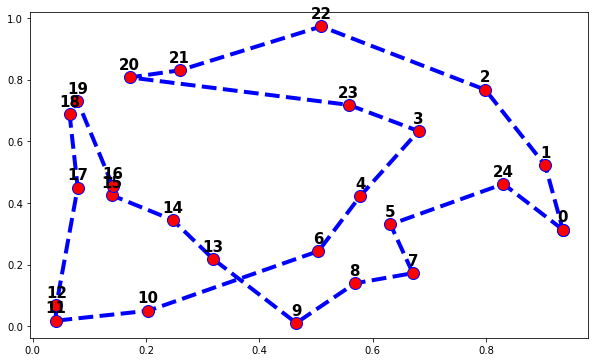

In [59]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

fig = plt.figure(figsize=(10,6))
for label in range(N):
            plt.annotate(label, (r[label,0],r[label,1]),fontsize=15,fontweight='bold',xytext=(0, 5),textcoords="offset points",ha='center', va='bottom')  
        
# Main loop
t = 0
T = Tmax
ims = []

while T>Tmin:

    # Cooling
    t += 1
    T = Tmax*exp(-t/tau)

    # Update the visualization every 100 moves
    if t%100==0:                      
        im, = plt.plot(r[:,0],r[:,1],color='blue', linestyle='dashed', linewidth='4',marker='o',markerfacecolor='red', markersize=12)  # plot returns a list of artists. This is so you can call plot like lines = plot(x1, y1, x2, y2,...). Adding the comma unpacks the length one list for ims.
        ims.append([im])
        
    # Choose two cities to swap and make sure they are distinct
    i,j = rng.integers(1,N),rng.integers(1,N)
    while i==j:
        i,j = rng.integers(1,N),rng.integers(1,N)

    # Swap them and calculate the change in distance
    oldD = D
    r[i,0],r[j,0] = r[j,0],r[i,0]
    r[i,1],r[j,1] = r[j,1],r[i,1]
    D = distance()
    deltaD = D - oldD

    # If the move is rejected, swap them back again
    if rng.random()>exp(-deltaD/T):
        r[i,0],r[j,0] = r[j,0],r[i,0]
        r[i,1],r[j,1] = r[j,1],r[i,1]
        D = oldD
        
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500)

writer = PillowWriter(fps=20)
ani.save("images/travel_route.gif", writer=writer)

plt.show()    

The results are generally pretty good, although rarely perfect for more complex systems. As always, improvements can be made at the expense of computational time, particularly by playing with the cooling rates and temperatures. Overall, this is a powerful general technique for optimizing functions and remains widely used.

![Final travel route](images/travel_route.gif)

#### Example - Parameters and speed

Explore how the quality of results you get depends on the parameters you use. As an advanced challenge, you can also consider how the code can be accelerated by vectorization - be aware, that the changes in efficiency can often be unintuitive. Also, for this problem the most obvious speedup would be achieved by parallelization, where multiple steps could be considered in parallel. 